In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

from tqdm.auto import tqdm

In [47]:
tqdm.pandas()

In [2]:
qpr = pd.read_csv('./qpr.csv')
liv = pd.read_csv('./liv.csv')

In [3]:
df = pd.concat((qpr, liv), axis = 0)

In [4]:
df.drop(columns = ['score', 'num_comments', 'id'], inplace = True)

In [5]:
df['team'] = df.subreddit.replace({
    'superhoops' : 0,
    'LiverpoolFC' : 1
})

In [6]:
X = df['body']
y = df['team']



In [7]:
y.value_counts(normalize = True)

1    0.966038
0    0.033962
Name: team, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify =y)

In [9]:
set_config(transform_output='pandas')

In [26]:
cvec = CountVectorizer(stop_words= 'english')

cvec.fit(X_train)

X_train_cv = cvec.transform(X_train)

X_test_cv = cvec.transform(X_test)

In [11]:
logr = LogisticRegression()

logr.fit(X_train_cv, y_train)



/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
print(logr.score(X_train_cv, y_train))
print(logr.score(X_test_cv, y_test))

0.9893557390926354
0.9842138677739838


In [14]:
X_train_cv.shape

(174836, 30158)

In [13]:
ros = RandomOverSampler(random_state=222, sampling_strategy=1)

X_train_over, y_train_over = ros.fit_resample(X_train_cv, y_train)

In [15]:
pd.DataFrame(y_train_over).value_counts()

team
0       168898
1       168898
dtype: int64

In [16]:
logr_over = LogisticRegression()

logr_over.fit(X_train_over, y_train_over)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
logr_over.score(X_train_over, y_train_over)

0.9803194827647456

In [18]:
logr_over.score(X_test_cv, y_test)

0.9632972425745122

In [19]:
pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=222)),
    ('logr', LogisticRegression(max_iter=10_000))
])

In [27]:
gs_bal = GridSearchCV(
    pipe,
    param_grid={'ros__sampling_strategy' : [0.9]},
    cv = 3,
    verbose = 1,
    scoring = 'balanced_accuracy'
)

In [28]:
gs_bal.fit(X_train_cv, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ros',
                                        RandomOverSampler(random_state=222)),
                                       ('logr',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'ros__sampling_strategy': [0.9]},
             scoring='balanced_accuracy', verbose=1)

In [22]:
gs_bal.best_params_

{'ros__sampling_strategy': 0.9}

In [29]:
gs_bal.best_estimator_.fit(X_train_cv, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=222, sampling_strategy=0.9)),
                ('logr', LogisticRegression(max_iter=10000))])

In [30]:
gs_bal.score(X_train_cv, y_train)

0.9864443307236467

In [31]:
gs_bal.score(X_test_cv, y_test)

0.8861955416419474

In [70]:
pa = Pipeline([
    ('ada', ADASYN(random_state=42, n_jobs = -1)),
    ('logr', LogisticRegression(max_iter=10_000))
])

In [76]:
gs_a = GridSearchCV(
    pa,
    param_grid={
        'ada__sampling_strategy': [0.1,0.3,0.9],
        'ada__n_neighbors' : [3, 5, 10],
        'logr__C': [0.1, 1, 10]
    }, scoring = 'balanced_accuracy', n_jobs = -1, cv = 2, verbose = 1
)

In [77]:
%timeit

gs_a.fit(X_train_cv, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has b

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has b

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ada',
                                        ADASYN(n_jobs=-1, random_state=42)),
                                       ('logr',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'ada__n_neighbors': [3, 5, 10],
                         'ada__sampling_strategy': [0.1, 0.3, 0.9],
                         'logr__C': [0.1, 1, 10]},
             scoring='balanced_accuracy', verbose=1)

In [78]:
gs_a.best_estimator_

Pipeline(steps=[('ada',
                 ADASYN(n_jobs=-1, n_neighbors=3, random_state=42,
                        sampling_strategy=0.1)),
                ('logr', LogisticRegression(C=10, max_iter=10000))])

In [79]:
gs_a.best_estimator_.fit(X_train_cv, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Pipeline(steps=[('ada',
                 ADASYN(n_jobs=-1, n_neighbors=3, random_state=42,
                        sampling_strategy=0.1)),
                ('logr', LogisticRegression(C=10, max_iter=10000))])

In [80]:
gs_a.score(X_train_cv, y_train)

0.9484729695156502

In [81]:
gs_a.score(X_test_cv, y_test)

0.8350114209860731

In [40]:
def get_accuracies(X_train, y_train, X_test, y_test, model, model_name:str, scores_df=None, norm=None):
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'bal_acc'])
    
    model.fit(X_train, y_train)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize=norm)
    
    preds = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    bal_acc = balanced_accuracy_score(y_test, preds)

    
    scores_df.loc[model_name,:] = [train_acc, test_acc, bal_acc]
    
    print(scores_df)
    
    return scores_df

             train_acc  test_acc   bal_acc
bal_ros_logr  0.984797  0.969457  0.886196


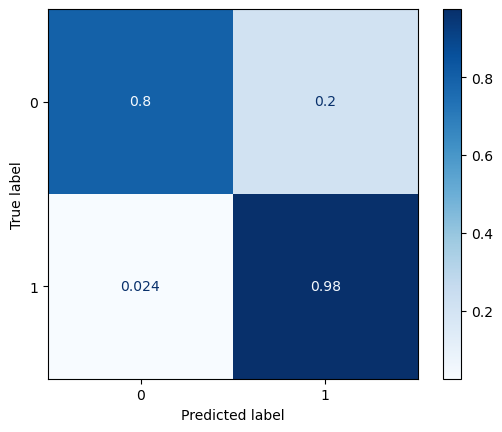

In [42]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_bal.best_estimator_, 'bal_ros_logr', norm = 'true')

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


             train_acc  test_acc   bal_acc
bal_ros_logr  0.984797  0.969457  0.886196
logr          0.990831  0.985329  0.810065


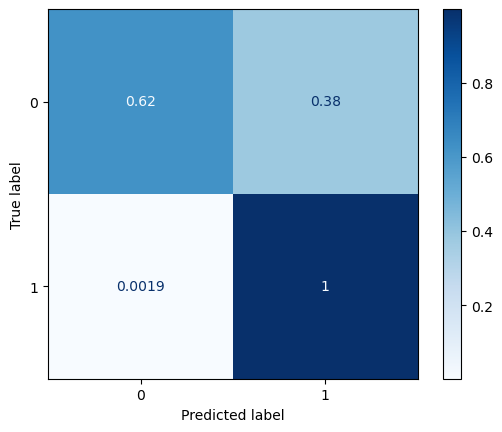

In [43]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, logr, 'logr', scores_df, norm = 'true')

In [44]:
pipe_mnb = Pipeline([
    ('ros', RandomOverSampler()),
    ('mnb', MultinomialNB())
])

In [65]:
gs_mnb = GridSearchCV(
    pipe_mnb,
    param_grid={
        'ros__sampling_strategy' : [0.2, 0.35, 0.5,0.9, 1],
        'mnb__alpha' : [1, 2, 3, 5, 7, 8]
    }, cv = 5, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [66]:
gs_mnb.fit(X_train_cv, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mnb__alpha': [1, 2, 3, 5, 7, 8],
                         'ros__sampling_strategy': [0.2, 0.35, 0.5, 0.9, 1]},
             scoring='balanced_accuracy', verbose=1)

In [67]:
gs_mnb.best_estimator_

Pipeline(steps=[('ros', RandomOverSampler(sampling_strategy=0.5)),
                ('mnb', MultinomialNB(alpha=3))])

In [68]:
gs_mnb.best_params_

{'mnb__alpha': 3, 'ros__sampling_strategy': 0.5}

             train_acc  test_acc   bal_acc
bal_ros_logr  0.984797  0.969457  0.886196
logr          0.990831  0.985329  0.810065
bal_ros_mnb   0.943318  0.939618  0.913168


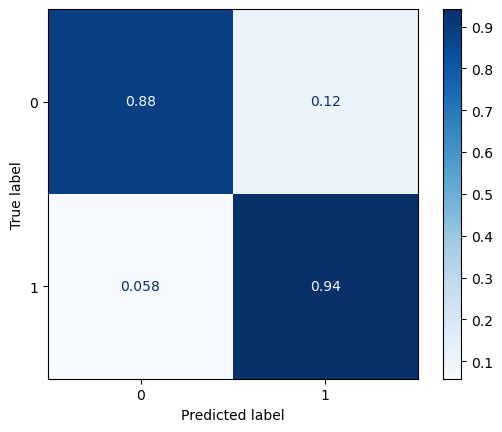

In [69]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_mnb.best_estimator_, 'bal_ros_mnb', scores_df, norm = 'true')

In [72]:
pipe_rf = Pipeline([
    ('ros', RandomOverSampler()),
    ('rf', RandomForestClassifier())
])

In [74]:
gs_rf = GridSearchCV(
    pipe_rf,
    param_grid = {
        'ros__sampling_strategy' :[0.5],
        'rf__max_depth' : [3,5,7],
        'rf__n_estimators' : [80, 100, 120]
    }, cv = 2, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [75]:
gs_rf.fit(X_train_cv, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5, 7],
                         'rf__n_estimators': [80, 100, 120],
                         'ros__sampling_strategy': [0.5]},
             scoring='balanced_accuracy', verbose=1)

             train_acc  test_acc   bal_acc
bal_ros_logr  0.984797  0.969457  0.886196
logr          0.990831  0.985329  0.810065
bal_ros_mnb   0.943318  0.939618  0.913168
bal_ros_rf    0.967101  0.966798  0.511117


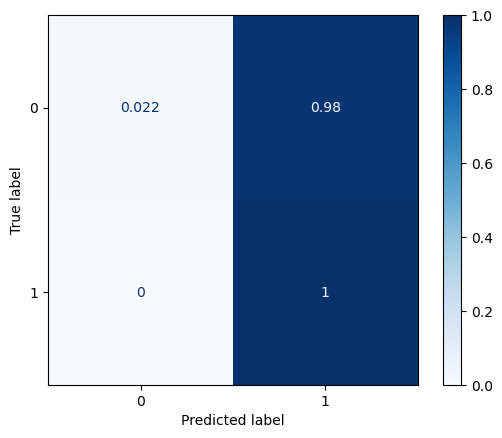

In [76]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_rf.best_estimator_, 'bal_ros_rf', scores_df, norm='true')

In [78]:
pipe_bnb = Pipeline([
    ('ros', RandomOverSampler()),
    ('bnb', BernoulliNB())
])

In [82]:
gs_bnb = GridSearchCV(
    pipe_bnb,
    param_grid={
        'ros__sampling_strategy' : [0.2, 0.35, 0.5,0.9],
        'bnb__alpha' : [0.1, 0.4, 0.6, 0.9, 1]
    }, cv = 5, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [83]:
gs_bnb.fit(X_train_cv, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bnb__alpha': [0.1, 0.4, 0.6, 0.9, 1],
                         'ros__sampling_strategy': [0.2, 0.35, 0.5, 0.9]},
             scoring='balanced_accuracy', verbose=1)

In [84]:
gs_bnb.best_estimator_

Pipeline(steps=[('ros', RandomOverSampler(sampling_strategy=0.9)),
                ('bnb', BernoulliNB(alpha=0.9))])

             train_acc  test_acc   bal_acc
bal_ros_logr  0.984797  0.969457  0.886196
logr          0.990831  0.985329  0.810065
bal_ros_mnb   0.943318  0.939618  0.913168
bal_ros_rf    0.967101  0.966798  0.511117
bal_ros_bnb   0.973364  0.968085  0.855257


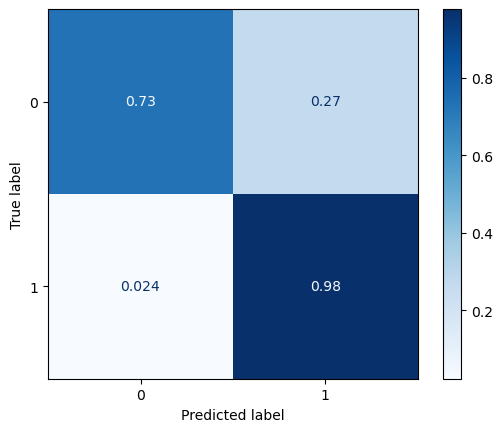

In [86]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_bnb.best_estimator_, 'bal_ros_bnb', scores_df, norm= 'true')

Pipeline(steps=[('ros', RandomOverSampler(random_state=222)),
                ('logr', LogisticRegression(max_iter=10000))])

In [122]:
stack = [
    ('mnb' , gs_mnb.best_estimator_),
    ('bnb' , gs_bnb.best_estimator_),
    ('lr' , LogisticRegression(max_iter = 100_000)),
#     ('et', gs_et.best_estimator_)
    
]

In [123]:
stx_mod = StackingClassifier(
    estimators=stack,
    final_estimator=gs_bal.best_estimator_
)

In [120]:
stx_mod.fit(X_train_cv, y_train)

KeyboardInterrupt: 

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, stx_mod, 'stack', scores_df, norm='true')

In [110]:
pipe_et = Pipeline([
    ('ros', RandomOverSampler()),
    ('et', ExtraTreesClassifier())
])

In [114]:
gs_et = GridSearchCV(
    pipe_et,
    param_grid={
        'ros__sampling_strategy' : [0.9],
        'et__min_samples_split' : [2,3],
        'et__max_depth' : [3,5]
    }, cv = 3, verbose= 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [115]:
gs_et.fit(X_train_cv, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [3, 5],
                         'et__min_samples_split': [2, 3],
                         'ros__sampling_strategy': [0.9]},
             scoring='balanced_accuracy', verbose=1)

In [116]:
gs_et.best_estimator_

Pipeline(steps=[('ros', RandomOverSampler(sampling_strategy=0.9)),
                ('et', ExtraTreesClassifier(max_depth=5, min_samples_split=3))])

             train_acc  test_acc   bal_acc
bal_ros_logr  0.984797  0.969457  0.886196
logr          0.990831  0.985329  0.810065
bal_ros_mnb   0.943318  0.939618  0.913168
bal_ros_rf    0.967101  0.966798  0.511117
bal_ros_bnb   0.973364  0.968085  0.855257
stack         0.952744  0.947889   0.92208
bal_ros_et    0.967673  0.967004  0.517318


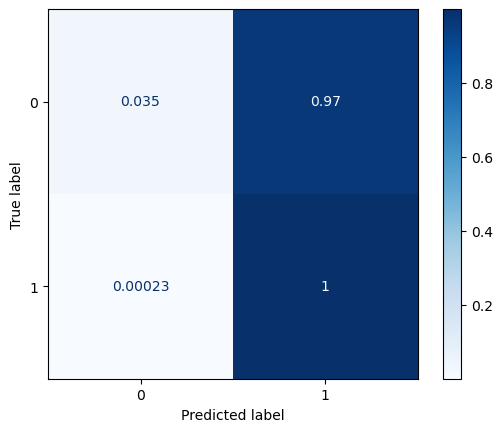

In [117]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_et.best_estimator_, 'bal_ros_et', scores_df, norm='true')

In [ ]:
# %%timeit
# # set dictionary to house best estimators and params
# best_models = {}
# # for loop through the 3 1st level keys of model_model dict
# for key, value in model_dict.items():
#     # set pipeline with Count Vectorizer
#     pipe = Pipeline([('cvec', CountVectorizer())])
#     # append current model iteration tuple
#     pipe.steps.append(value['model'])
#     print(pipe)
#     gs = GridSearchCV(pipe, # set as iteration of pipe
#                   value['params'], # set as iteration of pipe_params
#                       cv=5, # Cross Validation of 5
#                       n_jobs=-1) # Unlock CPU to help process
#     # fit the current iteration of GridSearchCV
#     gs.fit(X_train, y_train)
#     # save the best model and best params 
#     best_models[key] = {'model': gs.best_estimator_, 'params': gs.best_params_}
#     print(best_models)